In [66]:
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
import nltk
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from nltk.corpus import stopwords, words as english_words


In [67]:
nltk.download("stopwords")
nltk.download("words")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adamscarlat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/adamscarlat/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [68]:
# Authors Dataset

authors = pd.read_csv("./data/authors.csv")
authors.head()

,source_id,first_name,last_name,institution
0,27,Alan,Murray,NaN
1,27,Anthony,Smith,NaN
2,27,Zoe,Butler,NaN
3,63,Yaser,Abu-Mostafa,NaN
4,60,Michael,Fleisher,NaN


In [69]:
print (authors.info())
authors.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30237 entries, 0 to 30236
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source_id    30237 non-null  int64 
 1   first_name   30236 non-null  object
 2   last_name    30234 non-null  object
 3   institution  17302 non-null  object
dtypes: int64(1), object(3)
memory usage: 945.0+ KB
None


source_id          0
first_name         1
last_name          3
institution    12935
dtype: int64

In [70]:
# Paper dataset

papers = pd.read_csv("./data/papers.csv")
print (len(papers))
papers.head()


9680


,source_id,year,title,abstract,full_text
0,27,1987,Bit-Serial Neural Networks,NaN,573 \n\nBIT - SERIAL NEURAL NETWORKS \n\nAlan...
1,63,1987,Connectivity Versus Entropy,NaN,1 \n\nCONNECTIVITY VERSUS ENTROPY \n\nYaser S...
2,60,1987,The Hopfield Model with Multi-Level Neurons,NaN,278 \n\nTHE HOPFIELD MODEL WITH MUL TI-LEVEL N...
3,59,1987,How Neural Nets Work,NaN,442 \n\nAlan Lapedes \nRobert Farber \n\nThe...
4,69,1987,Spatial Organization of Neural Networks: A Pro...,NaN,740 \n\nSPATIAL ORGANIZATION OF NEURAL NEn...


In [71]:
print (papers.info())
print (papers.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9680 entries, 0 to 9679
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   source_id  9680 non-null   int64 
 1   year       9680 non-null   int64 
 2   title      9680 non-null   object
 3   abstract   6361 non-null   object
 4   full_text  9677 non-null   object
dtypes: int64(2), object(3)
memory usage: 378.3+ KB
None
source_id       0
year            0
title           0
abstract     3319
full_text       3
dtype: int64


In [72]:
# Impute the missing values
# It will impute the na column with title if it's na, use the original value if not

papers['full_text'] = np.where(papers['full_text'].isna(), papers['title'], papers['full_text'])
papers['abstract'] = np.where(papers['abstract'].isna(), papers['title'], papers['abstract'])

In [73]:
papers.isna().sum()

source_id    0
year         0
title        0
abstract     0
full_text    0
dtype: int64

# Preprocessing

### Text cleaning

In [74]:

def clean_text_column(df, text_column_name):
    # Define a set of English stopwords
    stop_words = set(stopwords.words("english"))

    # Define a set of valid English words
    english_words_set = set(english_words.words())

    # Helper function to clean a single text string
    def clean_text(text):
        # Remove non-alphabetic characters and convert to lowercase
        text = re.sub(r"[^a-zA-Z]", " ", text).lower()

        # Tokenize the text into words
        words = text.split()

        # Remove stopwords, single-letter words, and non-English words
        words = [word for word in words if word not in stop_words and len(word) > 1 and word in english_words_set]

        # Join the cleaned words back into a string
        cleaned_text = " ".join(words)

        return cleaned_text

    # Apply the clean_text function to the specified column
    df[text_column_name] = df[text_column_name].apply(clean_text)

    return df


clean_text_column(papers, 'full_text')


,source_id,year,title,abstract,full_text
0,27,1987,Bit-Serial Neural Networks,Bit-Serial Neural Networks,bit serial neural alan smith butler department...
1,63,1987,Connectivity Versus Entropy,Connectivity Versus Entropy,connectivity versus entropy abu institute tech...
2,60,1987,The Hopfield Model with Multi-Level Neurons,The Hopfield Model with Multi-Level Neurons,model ti level department electrical engineeri...
3,59,1987,How Neural Nets Work,How Neural Nets Work,alan theoretical division neural work national...
4,69,1987,Spatial Organization of Neural Networks: A Pro...,Spatial Organization of Neural Networks: A Pro...,spatial organization neural probabilistic mode...
...,...,...,...,...,...
9675,5452,2019,Discrete Object Generation with Reversible Ind...,The success of generative modeling in continuo...,discrete object generation reversible inductiv...
9676,4799,2019,Adaptively Aligned Image Captioning via Adapti...,Recent neural models for image captioning usua...,adaptively image via adaptive attention time w...
9677,1827,2019,Fully Dynamic Consistent Facility Location,We consider classic clustering problems in ful...,fully dynamic consistent facility location vin...
9678,8693,2019,Efficient Rematerialization for Deep Networks,"When training complex neural networks, memory ...",deep research mountain view ca research mounta...


### TF-IDF

In [75]:
# transforming the title using tf-idf (9680 titles containing 3397 unique words)

tfidf = TfidfVectorizer(max_df=0.8, min_df=2, max_features=5000, stop_words='english', token_pattern=r'(?u)\b[A-Za-z]+\b')
dtm = tfidf.fit_transform(papers['full_text'])

dtm.shape

(9680, 5000)

In [76]:
LDA = LatentDirichletAllocation(n_components=3, random_state=101)
LDA.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=101)

In [77]:
# 7 components and 3397 unique words
LDA.components_.shape

(5, 5000)

In [78]:
# In order to do this, we would need to apply the transform method on our LDA model and DTM to associate the topic to each
# article. Each title will be associated with probability for each LDA component
topic_results = LDA.transform(dtm)

# Now we will check the shape
topic_results.shape

(9680, 5)

In [79]:
# Probability of the first title to be associated to each topic (component)
topic_results[0]

array([0.82852575, 0.01640499, 0.01683958, 0.12204164, 0.01618804])

In [80]:
# Associating topic to each of the documents (index of highest probability)

papers['Topic'] = topic_results.argmax(axis=1)
papers.head(10)


,source_id,year,title,abstract,full_text,Topic
0,27,1987,Bit-Serial Neural Networks,Bit-Serial Neural Networks,bit serial neural alan smith butler department...,0
1,63,1987,Connectivity Versus Entropy,Connectivity Versus Entropy,connectivity versus entropy abu institute tech...,2
2,60,1987,The Hopfield Model with Multi-Level Neurons,The Hopfield Model with Multi-Level Neurons,model ti level department electrical engineeri...,2
3,59,1987,How Neural Nets Work,How Neural Nets Work,alan theoretical division neural work national...,3
4,69,1987,Spatial Organization of Neural Networks: A Pro...,Spatial Organization of Neural Networks: A Pro...,spatial organization neural probabilistic mode...,0
5,6,1987,A Neural-Network Solution to the Concentrator ...,A Neural-Network Solution to the Concentrator ...,neural network solution concentrator problem g...,2
6,33,1987,LEARNING BY STATE RECURRENCE DETECTION,LEARNING BY STATE RECURRENCE DETECTION,learning st ate recurrence university ca abstr...,3
7,36,1987,Stability Results for Neural Networks,Stability Results for Neural Networks,stability neural department electrical compute...,2
8,35,1987,Introduction to a System for Implementing Neur...,Introduction to a System for Implementing Neur...,introduction system neural net institute compu...,3
9,19,1987,Optimization with Artificial Neural Network Sy...,Optimization with Artificial Neural Network Sy...,non artificial neural network principle compar...,2


In [81]:
tfidf.get_feature_names_out()

array(['aa', 'abbasi', 'ability', ..., 'zo', 'zone', 'zoom'], dtype=object)

In [82]:
# print out the top 10 words with highest probabilities for all the ten topics. 

# Each topic is a vector of 3397 probabilities (for each unique word) for how much it matches the titles component.
# Take the top 10 words that have the highest probability to match the topic. For example the two words that match
# the first topic the most are "deep", "network"
for index, topic in enumerate(LDA.components_):
    print(f"THE TOP 15 WORDS FOR TOPIC #{index}")
    list_keywords = [tfidf.get_feature_names_out()[index] for index in topic.argsort()[-10:]]
    print(list_keywords)
    print("\n")

THE TOP 15 WORDS FOR TOPIC #0
['visual', 'cell', 'response', 'input', 'activity', 'synaptic', 'stimulus', 'network', 'spike', 'neuron']


THE TOP 15 WORDS FOR TOPIC #1
['server', 'differential', 'ode', 'accelerated', 'asynchronous', 'saga', 'communication', 'differentially', 'private', 'privacy']


THE TOP 15 WORDS FOR TOPIC #2
['let', 'error', 'convex', 'bound', 'distribution', 'kernel', 'theorem', 'xi', 'log', 'matrix']


THE TOP 15 WORDS FOR TOPIC #3
['task', 'recognition', 'state', 'object', 'policy', 'layer', 'deep', 'network', 'training', 'image']


THE TOP 15 WORDS FOR TOPIC #4
['stabilization', 'infected', 'carrier', 'therapy', 'unfairness', 'rim', 'adaptor', 'epitome', 'churn', 'labeler']




Topic
2    5478
3    3251
0     951
Name: count, dtype: int64

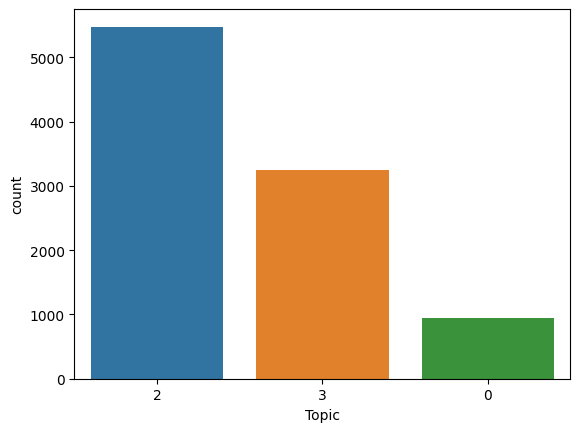

In [84]:
sns.countplot(x = 'Topic',
              data = papers,
              order = papers['Topic'].value_counts().index)

papers['Topic'].value_counts().sort_values(ascending=False)

In [107]:
def sample_titles_per_topic(papers_df, topic_num, sample_count = 5):
  indices = papers_df['Topic'][papers_df['Topic'] == topic_num].index
  
  for i in indices[:sample_count]:
    print (papers_df.iloc[i]["title"])

In [112]:
print ("Topic 0: ")
sample_titles_per_topic(papers, 0, 5)
print ("-"*100)
print ("Topic 2: ")
sample_titles_per_topic(papers, 2, 5)
print ("-"*100)
print ("Topic 3: ")
sample_titles_per_topic(papers, 3, 5)
print ("-"*100)


Topic 0: 
Bit-Serial Neural Networks
Spatial Organization of Neural Networks: A Probabilistic Modeling Approach
Optimal Neural Spike Classification
REFLEXIVE ASSOCIATIVE MEMORIES
Neuromorphic Networks Based on Sparse Optical Orthogonal Codes
----------------------------------------------------------------------------------------------------
Topic 2: 
Connectivity Versus Entropy
The Hopfield Model with Multi-Level Neurons
A Neural-Network Solution to the Concentrator Assignment Problem
Stability Results for Neural Networks
Optimization with Artificial Neural Network Systems: A Mapping Principle and a Comparison to Gradient Based Methods
----------------------------------------------------------------------------------------------------
Topic 3: 
How Neural Nets Work
LEARNING BY STATE RECURRENCE DETECTION
Introduction to a System for Implementing Neural Net Connections on SIMD Architectures
Speech Recognition Experiments with Perceptrons
On Tropistic Processing and Its Applications
-----